In [1]:
projectdir = "C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(pwd())

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, CSV, Pipe, ProgressMeter, StatsPlots, BSON
using Distributions, NLsolve, Roots, Random
pyplot()

try
    Turnover
catch e
    include(projectdir*"Turnover/src/Turnover.jl")
    include(projectdir*"Turnover/src/test.jl")
    using .Turnover
end
try
    SeqDataFormatting
catch e
    include("experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

include("scripts/distribution_functions.jl")
include("experimental_data/Li/Li_clustering.jl")
import TumorGrowth
plot(size=(1,1))

  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


Test Summary:             | Pass  Total
Applying turnover methods |    7      7


# Li data

In [2]:
tumor_name = "T1"
sanger = TumorGrowth.data_import("experimental_data/Li/Li_data_$(tumor_name)_sanger.tsv", delim="\t")
sanger.frequencies = [ones(Float64, length(m)) for m in sanger.mutations];

In [3]:
wes = TumorGrowth.data_import("experimental_data/Li/Li_data_$(tumor_name)_wes.tsv", delim="\t");

In [111]:
# sanger_lichee = data_import("experimental_data\\Li\\Li_data_$(tumor_name)_sanger_clones_lichee_sub100.tsv", delim="\t")
# lichee_tree = BSON.load("experimental_data\\Li\\lichee_data\\lichee_tree_Sanger.bson")
# lichee_tree = Dict( collect( keys(lichee_tree) ) .=> replace( collect( values(lichee_tree) ), Int[]=>[-1]) )
# sanger_lichee.frequencies = map( ones∘length, sanger_lichee.mutations)

sanger_coinc = TumorGrowth.data_import("experimental_data\\Li\\Li_data_$(tumor_name)_sanger_clones_coinc.tsv", delim="\t")
sanger_coinc.frequencies = map( ones∘length, sanger_coinc.mutations)

Lmax = length( union( sanger_coinc.mutations...) ) / length( union( wes.mutations...) )
;

In [112]:
n = nrow(sanger)
min_samples = 2
N = 2*n / min_samples
println(N)

turnover_params = ( f_min = min_samples, Nthresh_orph = N, Nthresh_estr = N, )

# tumor = deepcopy(sanger_lichee)
tumor = deepcopy(sanger_coinc)
# tumor = deepcopy(sanger);

freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict(df.mutation .=> df.frequency)
samplecounts = TumorGrowth.mutation_freqs(tumor) |> df -> Dict(df.mutation .=> df.reads);

168.0


## run parameter

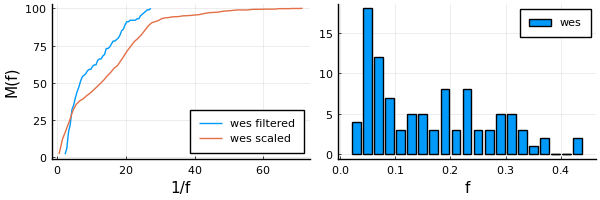

In [41]:
mutations = union(sanger_coinc.mutations...)
p = plot(layout=(1,2), size=(600,200))
M!(p[1], [freqs[m] for m in mutations], lab="wes filtered")
M!( p[1], collect(values(freqs)), scale=1/length(freqs)*length(mutations), lab="wes scaled", legend=:bottomright)
vaf_dist!(p[2], [freqs[m] for m in mutations], lab="wes", nBins=30)

In [7]:
# ds = map( 0.5:0.1:1. ) do L
#     map( 1:100 ) do _
#         orphaned_tumor = DataFrame( mutations = unique( 
#                 filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations) ) )
#         orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

#         # get d
#         W_l = orphaned_red_treeless(orphaned_tumor) |> 
#             df -> sum( df.isorphaned ) / sum( df.isgreen )

#         d_solve = try
#             fzero(x -> min(1., Turnover.W_orphaned( x;
#                         N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.001, 0.999)
#         catch e
#             e isa ArgumentError && NaN
#         end
#     end
# end
# filter!.(!isnan, ds)
# ds = vcat(ds...)
# d_solve = median(ds)

# estranged_tumor = DataFrame(mutations = filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )
# # get mu
# W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# # mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
# mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
#             T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)

# Ls = 0.4:0.1:1.
# reps = 300
# estranged_tumors = map( Ls ) do L
#     [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
# end

# estranged_turnover = map(estranged_tumors) do set
#         filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
#     end

# Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

# function model(Ls, p)
#     local mu = p[1]
#     (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
#     map( Ls ) do L
#         min(1., W_estranged(d_solve; b=1., μ=mu*L,
#                 T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))
#     end
# end
# # fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
# fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
#     vcat(t...), [(1-d_solve)/2])
# mu_fit = fitres.param[1]

# tvecs = [ rand.(t) for _=1:10000 ]
# fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
# mu_fits = getindex.(getfield.(fits, :param),1);

### re-cluster samples

In [110]:
nmuts*L

90.60000000000001

In [109]:
Random.seed!(1122)
ds = []
mus = []

min_samples, cutoff_hi, cutoff_lo, min_val_freq = 2, 1/2, Dict("T1"=>1/30, "T2"=>1/18), 1/5

nmuts = length(union(sanger.mutations...))
L = 0.1
@showprogress for L in L:0.05:L
    for _ in 1:50
        tumor = sanger_wes_coinc_clustering( sanger, wes; 
                min_samples = min_samples, cutoff_hi = cutoff_hi, cutoff_lo = cutoff_lo[tumor_name], 
                min_val_freq = min_val_freq, subsample_nmuts = ceil(Int,nmuts*L))
        samplecounts = TumorGrowth.mutation_freqs(tumor) |> df -> Dict(df.mutation .=> df.reads)
        
        try         
            orphaned_tumor = DataFrame( mutations = unique( 
                    filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations)
                ))
            
            estranged_tumor = DataFrame(mutations = unique(
                    filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts),
                    tumor.mutations)
                ))

            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |> 
                df -> sum( df.isorphaned ) / sum( df.isgreen )
            
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x;
                            N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.001, 0.999)
            
            # get mu
            W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen )
            
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 10)
            
            if 0.001 < d_solve < 0.999 #&& 0.001 < mu_solve < 0.999
                push!( ds, d_solve)
                push!(mus, mu_solve)
            end
        catch e
        end
    end
end

#### *L scaling analysis*

In [22]:
Lmax

0.5298013245033113

In [171]:
sort( countmap( tumor.mutations), by = length)

OrderedCollections.OrderedDict{Vector{Int64}, Int64} with 44 entries:
  []                                                                       => 67
  [387]                                                                    => 4
  [461]                                                                    => 1
  [449]                                                                    => 1
  [551]                                                                    => 12
  [615]                                                                    => 12
  [720, 754]                                                               => 1
  [753, 754, 761]                                                          => 1
  [657, 660, 679, 683]                                                     => 2
  [554, 586, 596, 616]                                                     => 1
  [720, 742, 754, 763]                                                     => 23
  [431, 449, 461, 487]                        

In [121]:
min_samples, cutoff_hi, cutoff_lo, min_val_freq = 2, 1/2, Dict("T1"=>1/30, "T2"=>1/18), 1/5

nmuts = length(union(sanger.mutations...))

906

In [16]:
for L in 0.5:-0.1:0.1
    Lmax=1/2
    println(L)
    let tumor = sanger_wes_coinc_clustering( sanger, wes; 
                min_samples = min_samples, cutoff_hi = cutoff_hi, cutoff_lo = cutoff_lo[tumor_name], 
                min_val_freq = min_val_freq, subsample_nmuts = ceil(Int,nmuts*L*Lmax))
        samplecounts = TumorGrowth.mutation_freqs(tumor) |> df -> Dict(df.mutation .=> df.reads)

        orphaned_tumor = DataFrame( mutations = unique( 
                        filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations)
                    ))
        # orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)        
        
        estranged_tumor = DataFrame(mutations = unique(
                    filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts),
                    tumor.mutations)
                ))
        # estranged_tumor = TumorGrowth.reduced_μ(estranged_tumor, L)

        W_l_df = orphaned_red_treeless(orphaned_tumor) 
        W_l = sum( W_l_df.isorphaned ) / sum( W_l_df.isgreen )

        d_solve = fzero(x -> min(1., Turnover.W_orphaned( x;
                                    N= turnover_params[:Nthresh_orph]*(1-x))) - W_l,
            0.001, 0.999)

        println("\t",  round.( (nrow(W_l_df), sum(W_l_df.isorphaned), sum(W_l_df.isgreen), W_l, d_solve ), digits=2))

        # get mu
        W_c_df = estranged_treeless(estranged_tumor)
        W_c = sum( W_c_df.isestranged ) / sum( W_c_df.isgreen )
        

        mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu*L,
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 10)

        println("\t",   round.((nrow(W_c_df), sum(W_c_df.isestranged), sum(W_c_df.isgreen), W_c, mu_solve ), digits=2))
        
        @show hcat( first( sort(W_l_df, :isorphaned, rev=true), 10), first( sort(W_c_df, :isestranged, rev=true), 10),
            makeunique=true)
    end
end

0.5
	(215.0, 743.0, 7967.0, 0.09, 0.72)
	(215.0, 45.0, 60.0, 0.75, 0.49)
hcat(first(sort(W_l_df, :isorphaned, rev = true), 10), first(sort(W_c_df, :isestranged, rev = true), 10), makeunique = true) = 10×6 DataFrame
 Row │ mutation  isorphaned  isgreen  mutation_1  isestranged  isgreen_1
     │ Int64     Float64     Float64  Int64       Float64      Float64
─────┼───────────────────────────────────────────────────────────────────
   1 │      426        13.0     18.0           8          1.0        1.0
   2 │      429        13.0     18.0          19          1.0        1.0
   3 │      435        13.0     18.0         725          1.0        1.0
   4 │      437        13.0     18.0         744          1.0        1.0
   5 │      438        13.0     18.0         762          1.0        1.0
   6 │      441        13.0     18.0         702          1.0        1.0
   7 │      444        13.0     18.0         710          1.0        1.0
   8 │      447        13.0     18.0         704        

In [78]:
for L in 0.5:-0.1:0.1
    println(L)
    let tumor = sanger_wes_coinc_clustering( sanger, wes; 
                min_samples = min_samples, cutoff_hi = cutoff_hi, cutoff_lo = cutoff_lo[tumor_name], 
                min_val_freq = min_val_freq, subsample_nmuts = ceil(Int,nmuts*L*Lmax))
        samplecounts = TumorGrowth.mutation_freqs(tumor) |> df -> Dict(df.mutation .=> df.reads)

        orphaned_tumor = DataFrame( mutations = unique( 
                        filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations)
                    ))
        # orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        estranged_tumor = DataFrame(mutations = unique(
                    filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts),
                    tumor.mutations)
                ))
        # estranged_tumor = TumorGrowth.reduced_μ(estranged_tumor, L)

        W_l_df = orphaned_red_treeless(orphaned_tumor) 
        W_l = sum( W_l_df.isorphaned ) / sum( W_l_df.isgreen )

        d_solve = fzero(x -> min(1., Turnover.W_orphaned( x;
                                    N= turnover_params[:Nthresh_orph]*(1-x))) - W_l,
            0.001, 0.999)

        println("\t",  round.( (nrow(W_l_df), sum(W_l_df.isorphaned), sum(W_l_df.isgreen), W_l, d_solve ), digits=2))

        # get mu
        W_c_df = estranged_treeless(estranged_tumor)
        W_c = sum( W_c_df.isestranged ) / sum( W_c_df.isgreen )

        mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu*L,
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 10)

        println("\t",   round.((nrow(W_c_df), sum(W_c_df.isestranged), sum(W_c_df.isgreen), W_c, mu_solve ), digits=2))
    end
end

0.5
	(227.0, 720.0, 7771.0, 0.09, 0.72)
	(227.0, 56.0, 64.0, 0.88, 0.53)
0.4
	(188.0, 531.0, 7106.0, 0.07, 0.62)
	(188.0, 44.0, 50.0, 0.88, 0.9)
0.3
	(138.0, 222.0, 2650.0, 0.08, 0.67)
	(138.0, 43.0, 49.0, 0.88, 1.03)
0.2
	(93.0, 169.0, 1102.0, 0.15, 0.89)
	(93.0, 25.0, 34.0, 0.74, 0.45)
0.1
	(47.0, 30.0, 292.0, 0.1, 0.76)
	(47.0, 16.0, 26.0, 0.62, 1.85)


#### *orphans on tree*

In [131]:
mutation_turnover_scores = SeqDataFormatting.mfreqs(wes)
sanger_freqs = TumorGrowth.mutation_freqs(sanger)
mutation_turnover_scores.reads[sanger_freqs.mutation] = sanger_freqs.reads
mutation_turnover_scores.coverage[sanger_freqs.mutation] = sanger_freqs.coverage
mutation_turnover_scores.orphaned = zeros(nrow(mutation_turnover_scores))
mutation_turnover_scores.estranged = zeros(nrow(mutation_turnover_scores))
first( mutation_turnover_scores,  3)

,mutation,reads,coverage,frequency,orphaned,estranged
,Int64,Float64,Float64,Float64,Float64,Float64
1,1,4.0,168.0,0.0587599,0.0,0.0
2,2,3.0,168.0,0.0488464,0.0,0.0
3,3,1.0,168.0,0.0609229,0.0,0.0


In [132]:
for L in 0.5:-0.1:0.1
    Lmax=1/2
    let tumor_ = sanger_wes_coinc_clustering( sanger, wes; 
                min_samples = min_samples, cutoff_hi = cutoff_hi, cutoff_lo = cutoff_lo[tumor_name], 
                min_val_freq = min_val_freq, subsample_nmuts = ceil(Int,nmuts*L*Lmax))
        samplecounts = TumorGrowth.mutation_freqs(tumor_) |> df -> Dict(df.mutation .=> df.reads)

        orphaned_tumor = DataFrame( mutations = unique( 
                        filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor_.mutations)
                    ))
        # orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)        
        
        estranged_tumor = DataFrame(mutations = unique(
                    filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts),
                    tumor_.mutations)
                ))
        # estranged_tumor = TumorGrowth.reduced_μ(estranged_tumor, L)

        W_l_df = orphaned_red_treeless(orphaned_tumor) 
        W_l = sum( W_l_df.isorphaned ) / sum( W_l_df.isgreen )

        d_solve = fzero(x -> min(1., Turnover.W_orphaned( x;
                                    N= turnover_params[:Nthresh_orph]*(1-x))) - W_l,
            0.001, 0.999)

        # get mu
        W_c_df = estranged_treeless(estranged_tumor)
        W_c = sum( W_c_df.isestranged ) / sum( W_c_df.isgreen )
        

        mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu*L,
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 10)
        
        mutation_turnover_scores.orphaned[W_l_df.mutation] += W_l_df.isorphaned ./ W_l_df.isgreen
        mutation_turnover_scores.estranged[W_c_df.mutation] += W_c_df.isestranged ./ W_c_df.isgreen
    end
end

In [151]:
most_orphaned = first( filter(r->!isnan(r.orphaned), sort( mutation_turnover_scores, :orphaned, rev=true)),  500)
most_estranged = first( filter(r->!isnan(r.estranged), sort( mutation_turnover_scores, :estranged, rev=true)), 500);

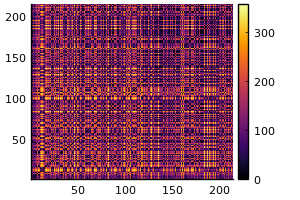

In [152]:
mutations = unique(vcat(sanger.mutations...))
mut2clone = Dict(mutations .=> map(mutations) do m
    intersect(filter(muts -> m in muts, sanger.mutations)...)
end)
coinc_clones = unique(values(mut2clone))

clone2ind = Dict(coinc_clones .=> 1:length(coinc_clones))
mut2ind = Dict(mutations .=> [ clone2ind[mut2clone[m]] for m in mutations])

dependencies = pairwise(coinc_clones, coinc_clones) do m1, m2
    length(union(setdiff(m1, m2), setdiff(m2, m1)))
end
heatmap(dependencies, size=(300,200))

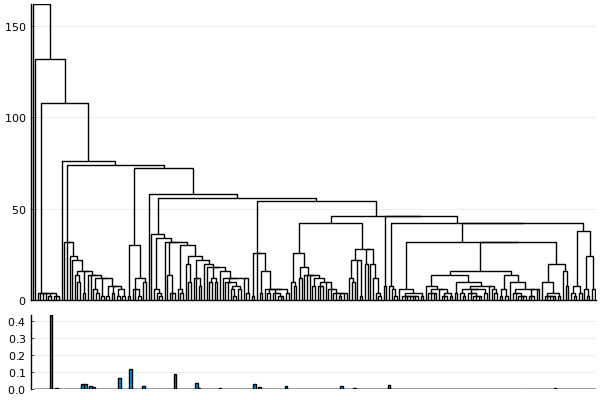

In [156]:
using StatsPlots, Clustering

hcl = hclust(dependencies , linkage = :single)
hcl.heights .*=2

ticks = [mut2ind[m] for m in most_orphaned.mutation]

xticks = (getindex(1:nrow(mutation_turnover_scores), [findfirst(isequal(tick), hcl.order) for tick in ticks]),ticks)
plot(
    plot(hcl, useheight=true, xticks=:none),
    histogram(xticks[1], weights= most_orphaned.orphaned ./ sum(most_orphaned.orphaned),
        xticks=:none, xaxis=:off, bins=1:size(dependencies,1), ylim=(0,:auto), lab="", xlim=(0,size(dependencies,1))),  
        layout = grid(2, 1, heights=[0.8 ,0.2])
)

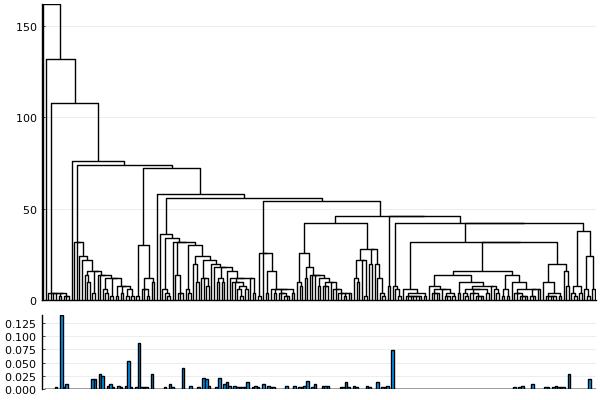

In [157]:
using StatsPlots, Clustering

hcl = hclust(dependencies , linkage = :single)
hcl.heights .*=2

ticks = [mut2ind[m] for m in most_estranged.mutation]

xticks = (getindex(1:nrow(mutation_turnover_scores), [findfirst(isequal(tick), hcl.order) for tick in ticks]),ticks)
plot(
    plot(hcl, useheight=true, xticks=:none),
    histogram(xticks[1], weights= most_estranged.estranged ./ sum(most_estranged.estranged),
        xticks=:none, xaxis=:off, bins=1:size(dependencies,1), ylim=(0,:auto), lab="", xlim=(0,size(dependencies,1))),  
        layout = grid(2, 1, heights=[0.8 ,0.2])
)

> first 30

[26, 26, 64, 26, 26, 26, 26, 26, 26, 26, 26, 26, 117, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 30, 26, 26, 64, 26, 26, 26]


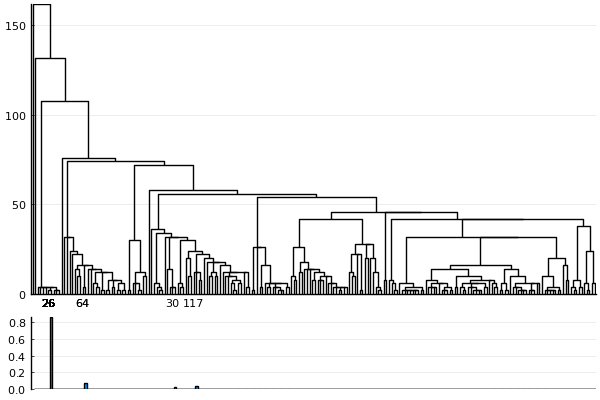

In [145]:
using StatsPlots, Clustering

hcl = hclust(dependencies , linkage = :single)
hcl.heights .*=2

ticks = [mut2ind[m] for m in most_orphaned.mutation]
println(ticks)

xticks = (getindex(1:nrow(mutation_turnover_scores), [findfirst(isequal(tick), hcl.order) for tick in ticks]),ticks)
plot(
    plot(hcl, useheight=true, xticks=xticks),
    histogram(xticks[1], weights= most_orphaned.orphaned ./ sum(most_orphaned.orphaned),
        xticks=:none, xaxis=:off, bins=1:size(dependencies,1), ylim=(0,:auto), lab="", xlim=(0,size(dependencies,1))),  
        layout = grid(2, 1, heights=[0.8 ,0.2])
)

[10, 5, 110, 99, 101, 80, 80, 5, 5, 118, 118, 118, 21, 30, 13, 13, 26, 104, 5, 5, 69, 49, 110, 64, 154, 10, 37, 153, 160, 117]


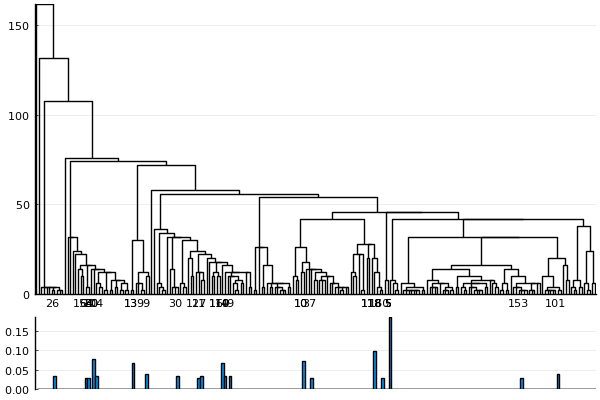

In [146]:
using StatsPlots, Clustering

hcl = hclust(dependencies , linkage = :single)
hcl.heights .*=2

ticks = [mut2ind[m] for m in most_estranged.mutation]
println(ticks)

xticks = (getindex(1:nrow(mutation_turnover_scores), [findfirst(isequal(tick), hcl.order) for tick in ticks]),ticks)
plot(
    plot(hcl, useheight=true, xticks=xticks),
    histogram(xticks[1], weights= most_estranged.estranged ./ sum(most_estranged.estranged),
        xticks=:none, xaxis=:off, bins=1:size(dependencies,1), ylim=(0,:auto), lab="", xlim=(0,size(dependencies,1))),  
        layout = grid(2, 1, heights=[0.8 ,0.2])
)

> first 60

[26, 26, 30, 30, 64, 117, 26, 26, 154, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 154, 13, 26, 30, 30, 64, 117, 117, 30, 30, 30, 13, 13, 13, 26, 26, 26, 26, 26, 13, 13, 13, 13, 13, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 80, 26, 26, 26, 26, 26, 9, 99, 99, 99, 99, 80, 80, 9, 13, 26, 13, 13, 13, 13, 13, 13, 28, 9, 9, 9, 9, 41, 28, 13, 13, 13, 13, 13, 13, 5, 20, 5, 105]


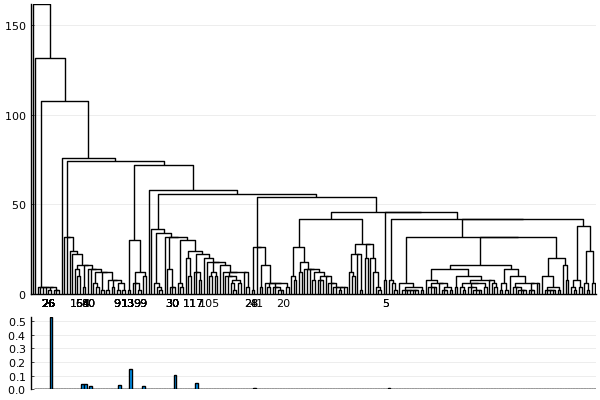

In [149]:
using StatsPlots, Clustering

hcl = hclust(dependencies , linkage = :single)
hcl.heights .*=2

ticks = [mut2ind[m] for m in most_orphaned.mutation]
println(ticks)

xticks = (getindex(1:nrow(mutation_turnover_scores), [findfirst(isequal(tick), hcl.order) for tick in ticks]),ticks)
plot(
    plot(hcl, useheight=true, xticks=xticks),
    histogram(xticks[1], weights= most_orphaned.orphaned ./ sum(most_orphaned.orphaned),
        xticks=:none, xaxis=:off, bins=1:size(dependencies,1), ylim=(0,:auto), lab="", xlim=(0,size(dependencies,1))),  
        layout = grid(2, 1, heights=[0.8 ,0.2])
)

[105, 105, 64, 154, 10, 21, 117, 30, 30, 13, 26, 26, 187, 104, 5, 5, 200, 36, 36, 58, 110, 89, 64, 154, 37, 153, 118, 10, 162, 43, 141, 117, 21, 207, 111, 30, 30, 13, 13, 99, 13, 99, 13, 13, 13, 26, 26, 26, 26, 26, 26, 26, 103, 26, 26, 98, 96, 38, 50, 199, 15, 15, 80, 80, 104, 16, 9, 5, 5, 5, 5, 63, 63, 144, 69, 49, 59, 58, 105, 110, 110, 86, 151, 64, 154, 150, 6, 42, 191, 37, 118, 100, 118, 160, 191, 134, 90, 179, 175, 117]


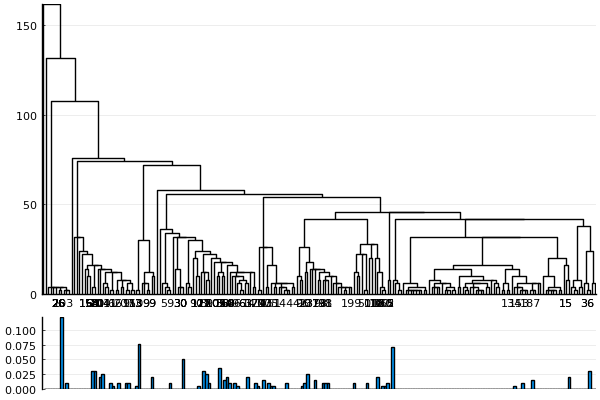

In [150]:
using StatsPlots, Clustering

hcl = hclust(dependencies , linkage = :single)
hcl.heights .*=2

ticks = [mut2ind[m] for m in most_estranged.mutation]
println(ticks)

xticks = (getindex(1:nrow(mutation_turnover_scores), [findfirst(isequal(tick), hcl.order) for tick in ticks]),ticks)
plot(
    plot(hcl, useheight=true, xticks=xticks),
    histogram(xticks[1], weights= most_estranged.estranged ./ sum(most_estranged.estranged),
        xticks=:none, xaxis=:off, bins=1:size(dependencies,1), ylim=(0,:auto), lab="", xlim=(0,size(dependencies,1))),  
        layout = grid(2, 1, heights=[0.8 ,0.2])
)

### re-sample clusters

In [85]:
Random.seed!(1122)
ds = []
mus = []
@showprogress for L in 0.4:0.05:1
    for _ in 1:50
        try         
            orphaned_tumor = DataFrame( mutations = unique( 
                    filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations)
                ))
            orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
            
            estranged_tumor = DataFrame(mutations = unique(
                    filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts),
                    tumor.mutations)
                ))
            estranged_tumor = TumorGrowth.reduced_μ(estranged_tumor, L)

            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |> 
                df -> sum( df.isorphaned ) / sum( df.isgreen )
            
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x;
                            N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.001, 0.999)
            
            # get mu
            W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen )
            
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)
            if 0.001 < d_solve < 0.999 && 0.001 < mu_solve < 0.999
                push!( ds, d_solve)
                push!(mus, mu_solve)
            end
        catch e
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [225]:
Random.seed!(1122)
ds = []
mus = []
@showprogress for L in 0.5:0.1:1.
    
    tumors = map( 1:50 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
            filter.(m-> samplecounts[m] > turnover_params[:f_min], tumor.mutations)
        ))
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        estranged_tumor = DataFrame(mutations = unique(
                filter( muts -> all(  samplecounts[m] > turnover_params[:f_min] for m in muts),
                tumor.mutations)
            ))
        estranged_tumor = TumorGrowth.reduced_μ(estranged_tumor, L)
        
        orphaned_tumor, estranged_tumor
    end
    
    unique!(tumors)
    
    for (orphaned_tumor, estranged_tumor) in tumors
        try         
            # get d
            W_l = orphaned_red_treeless(orphaned_tumor) |> 
                df -> sum( df.isorphaned ) / sum( df.isgreen )
            
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x;
                            N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.001, 0.999)
            
            # get mu
            W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen )
            
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)
            
            push!( ds, d_solve)
            push!(mus, mu_solve)
        catch e
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [227]:
last( ds), last( mus)

(0.7018826147933629, 0.26195100987699615)

# T1

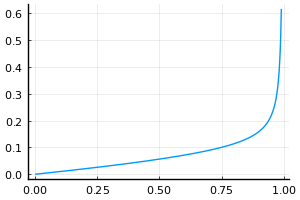

In [12]:
plot(0.:0.001:0.99, d -> Turnover.W_orphaned( d; N= turnover_params[:Nthresh_orph]*(1-d)),lab="", size=(300,200))

L0.3
0.7074358155750146
0.9193399255328847


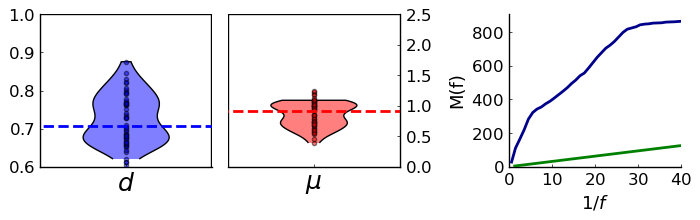

In [62]:
println("L", L)
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 2.5)
yticks = range(ylim..., step=0.5)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,:auto), c=:darkblue, scale=1)
plot!(p[end], 1:40, x-> x*median(mus)/(1-median(ds)), lw=2., lab="", c=:green)

In [70]:
0.919 * 3/2

1.3785

L0.2
0.7112529905505411
1.3321886044410243


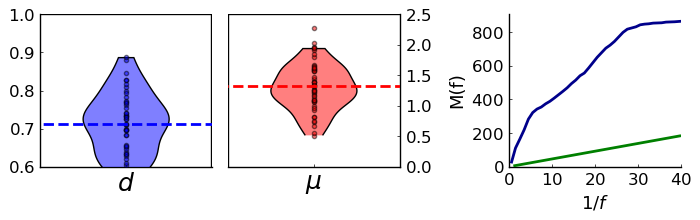

In [68]:
println("L", L)
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 2.5)
yticks = range(ylim..., step=0.5)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,:auto), c=:darkblue, scale=1)
plot!(p[end], 1:40, x-> x*median(mus)/(1-median(ds)), lw=2., lab="", c=:green)

In [71]:
0.919 * 3/1

2.757

L0.1
0.7806413769191642
1.8347363811452402


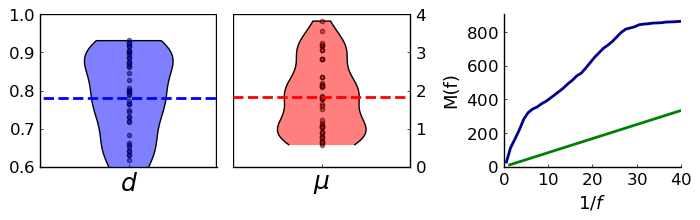

In [80]:
println("L", L)
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 4)
yticks = range(ylim..., step=1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,:auto), c=:darkblue, scale=1)
plot!(p[end], 1:40, x-> x*median(mus)/(1-median(ds)), lw=2., lab="", c=:green)

L0.05
0.7550654356270081
3.7804790879933603


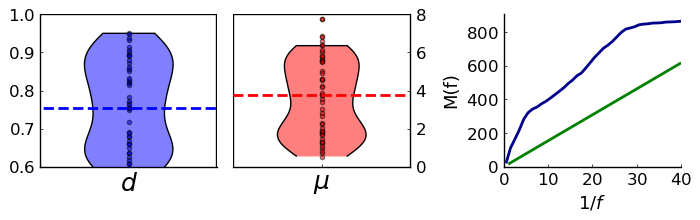

In [76]:
println("L", L)
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 8)
yticks = range(ylim..., step=2)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,:auto), c=:darkblue, scale=1)
plot!(p[end], 1:40, x-> x*median(mus)/(1-median(ds)), lw=2., lab="", c=:green)

Lmax * Lsub 0.5298013245033113
0.7266102535439717
1.067077429369423


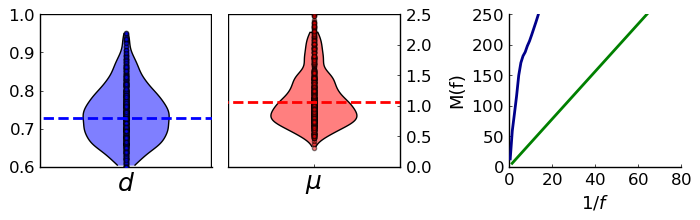

In [27]:
println("Lmax * Lsub ", Lmax*Lsub)
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 2.5)
yticks = range(ylim..., step=0.5)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,250), c=:darkblue, scale=Lmax*Lsub)
plot!(p[end], 1:80, x-> x*median(mus)/(1-median(ds)), lw=2., lab="", c=:green)

Lmax * Lsub 0.26490066225165565
0.7569637650706476
0.8916282387873246


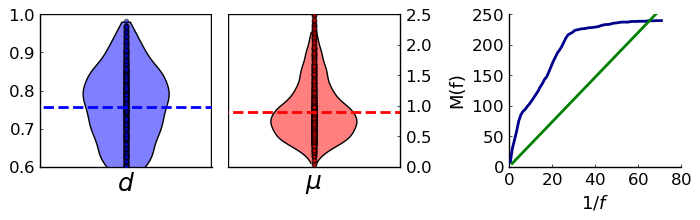

In [25]:
println("Lmax * Lsub ", Lmax*Lsub)
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 2.5)
yticks = range(ylim..., step=0.5)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,250), c=:darkblue, scale=Lmax*Lsub)
plot!(p[end], 1:80, x-> x*median(mus)/(1-median(ds)), lw=2., lab="", c=:green)

Lmax * Lsub 0.26490066225165565
0.7145937531748352
0.48607980670429507


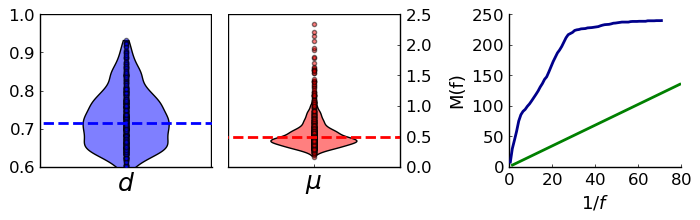

In [29]:
println("Lmax * Lsub ", Lmax*Lsub)
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 2.5)
yticks = range(ylim..., step=0.5)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,250), c=:darkblue, scale=Lmax*Lsub)
plot!(p[end], 1:80, x-> x*median(mus)/(1-median(ds)), lw=2., lab="", c=:green)

Lmax * Lsub 0.26490066225165565
0.7073993545379242
0.4153651469193258


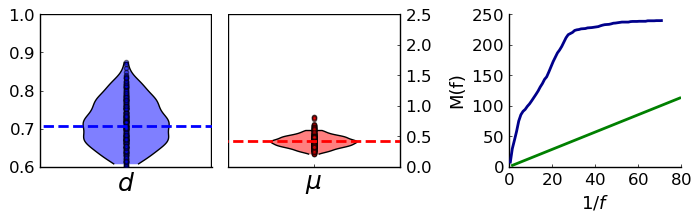

In [31]:
println("Lmax * Lsub ", Lmax*Lsub)
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 2.5)
yticks = range(ylim..., step=0.5)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,250), c=:darkblue, scale=Lmax*Lsub)
plot!(p[end], 1:80, x-> x*median(mus)/(1-median(ds)), lw=2., lab="", c=:green)

## *simple/coincidence clustering*

> full

0.6852501155167324
0.7134144348431365


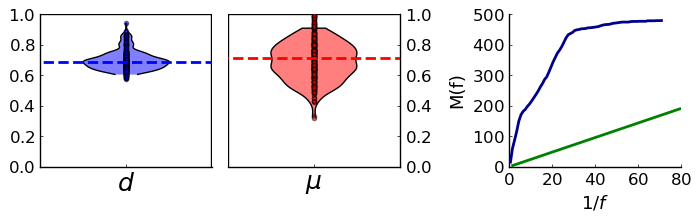

In [71]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.,1)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 1)
yticks = range(ylim..., step=0.2)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus) ], c=:red, lw=2., style=:dash)
hline!(p[2], [median(mus) / Lmax ], c=:black, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,500), c=:darkblue,  scale=Lmax)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

0.7080651534989346
0.25100381300181984


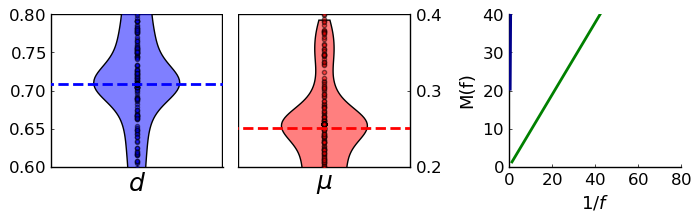

In [176]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, .8)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.2, 0.4)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus) ], c=:red, lw=2., style=:dash)
hline!(p[2], [median(mus) / Lmax ], c=:black, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue,  scale=Lmax)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

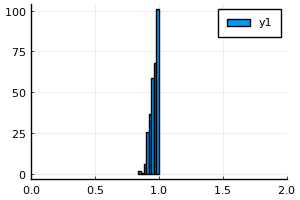

In [27]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

0.6686340618321786
0.30685824060101125


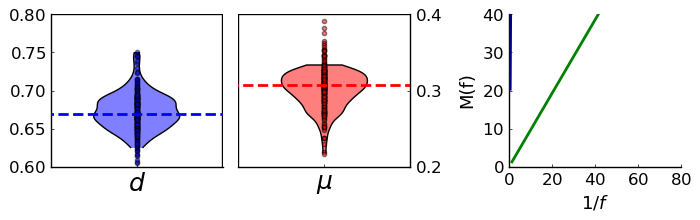

In [83]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, .8)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.2, 0.4)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

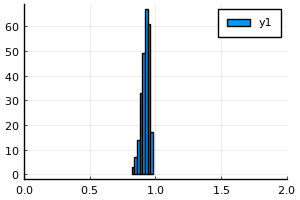

In [84]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

> sub 100

0.6860707257542543
0.3464792116414931


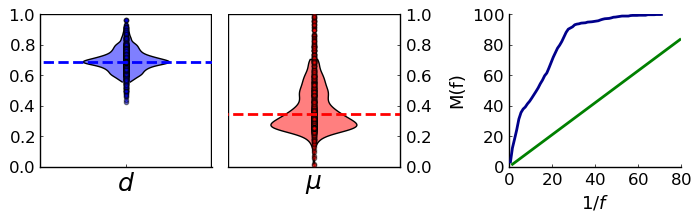

In [80]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.,1)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 1)
yticks = range(ylim..., step=0.2)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus) ], c=:red, lw=2., style=:dash)
hline!(p[2], [median(mus) / Lmax ], c=:black, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,:auto), c=:darkblue,  scale=Lmax)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

0.6860707257542543
0.25182411414567735


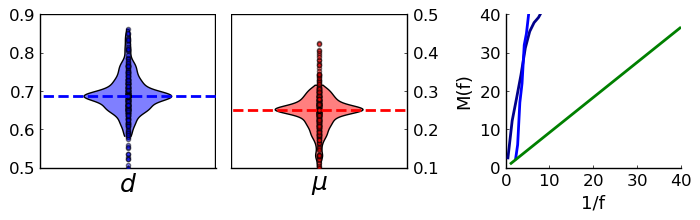

In [55]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

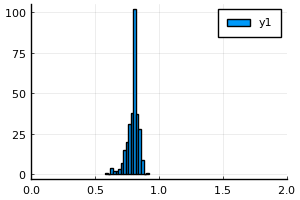

In [56]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

0.6835570931974627
0.25143181652688884


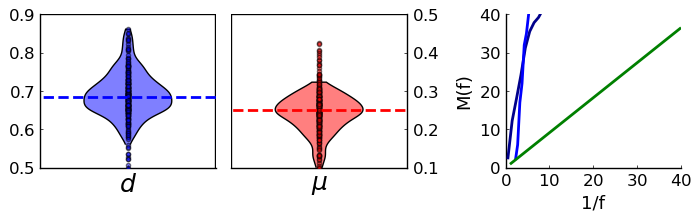

In [60]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

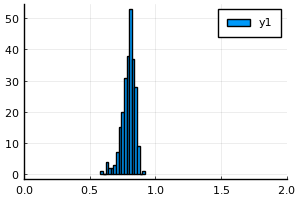

In [61]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

> sub 50

0.6433563906982572
0.35302916457005906


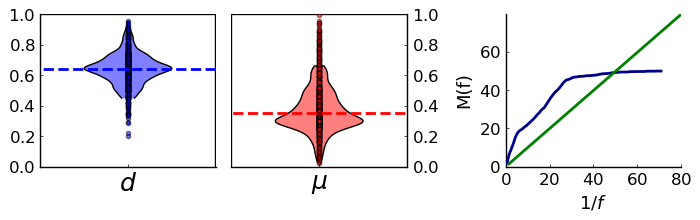

In [88]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.,1)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 1)
yticks = range(ylim..., step=0.2)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus) ], c=:red, lw=2., style=:dash)
hline!(p[2], [median(mus) / Lmax ], c=:black, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,:auto), c=:darkblue,  scale=Lmax)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

0.6433563906982572
0.29889100311990935


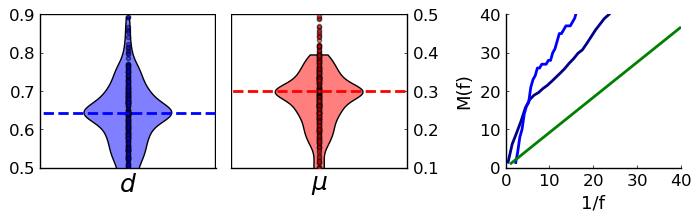

In [66]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

0.6433563906982572
0.3379351624554636


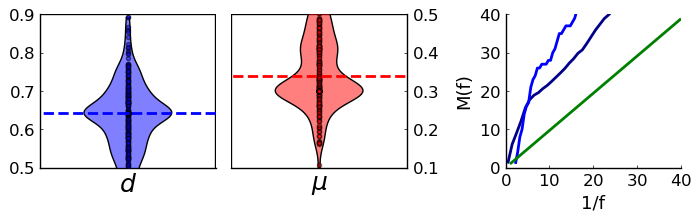

In [214]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

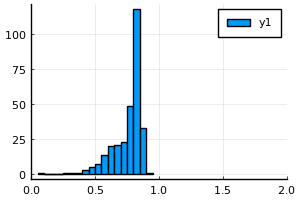

In [67]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

0.6203644936586614
0.28341615997499775


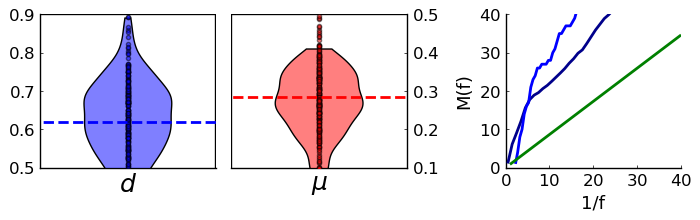

In [73]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

0.6247824181045137
0.3876388119181945


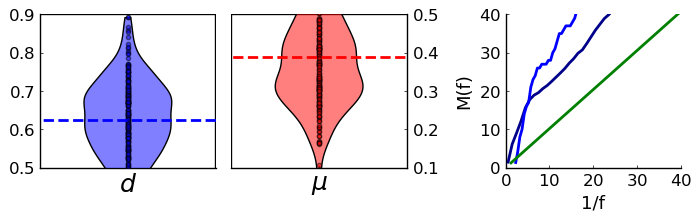

In [217]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

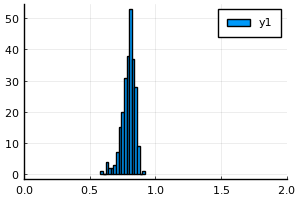

In [61]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

> sub 35

0.6237030311102626
0.27778639647727965


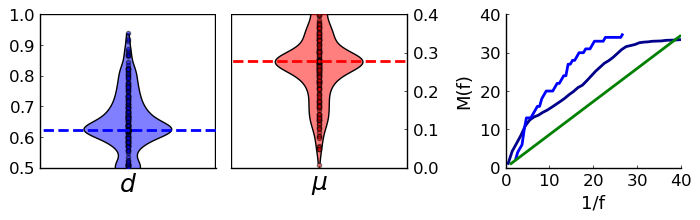

In [248]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.4)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

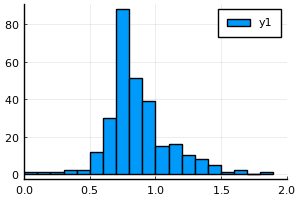

In [249]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

# T2

## *simple/coincidence clustering*

> full

0.7077401423312014
0.25593272351235036


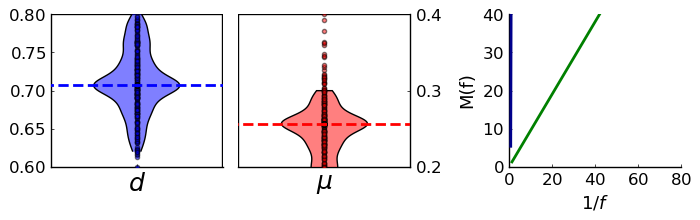

In [91]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, .8)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.2, 0.4)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

In [20]:
quantile(ds,0.025), median(ds),  quantile(ds,0.975)

(0.5093397590172661, 0.5739377149938167, 0.6667279636206754)

In [23]:
quantile(mus,0.025), median(mus), quantile(mus,0.975)

(0.3102515565830103, 0.41413961020155676, 0.46182973155226464)

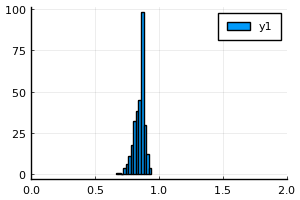

In [92]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

0.706357704633808
0.24765190843461216


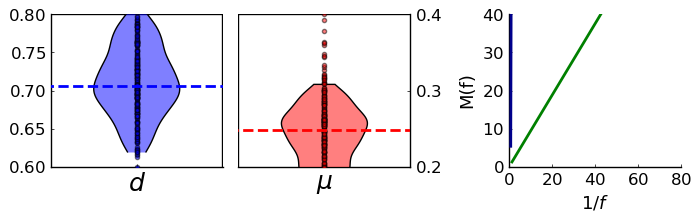

In [94]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.6, .8)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.2, 0.4)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/80
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], SeqDataFormatting.mfreqs(wes).frequency, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue)
plot!(p[end], 1:80, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

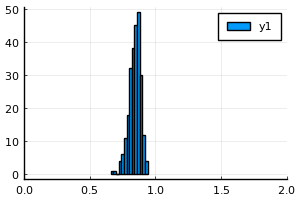

In [95]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

> sub 100

0.7118012718585544
0.24323726990383576


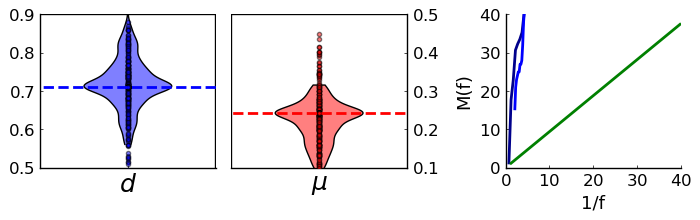

In [100]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

0.7118012718585544
0.2829715788808419


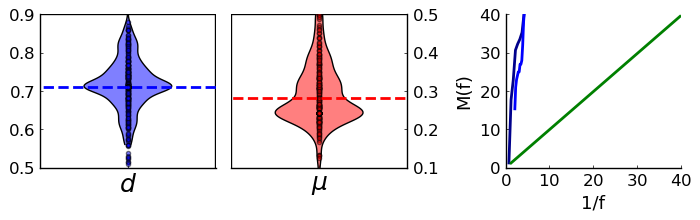

In [231]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

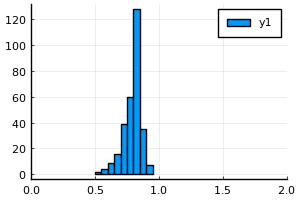

In [101]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

0.7162094318442077
0.2291890080135447


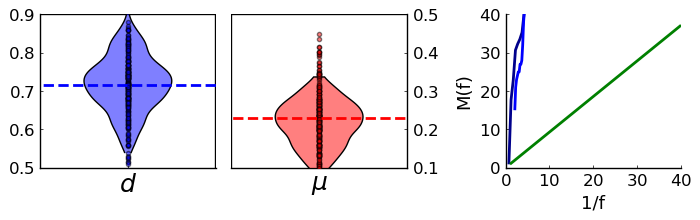

In [103]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

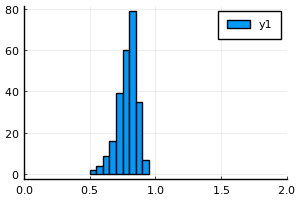

In [104]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

> sub 50

0.7018826147933629
0.2559540962069539


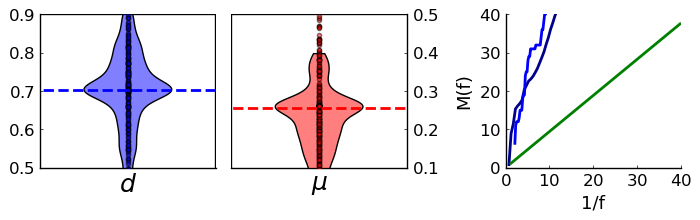

In [109]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

0.7018826147933629
0.26649256734342974


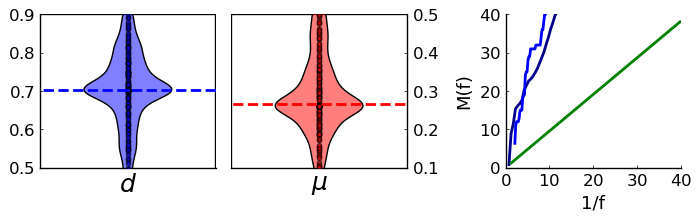

In [224]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

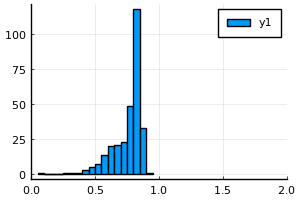

In [67]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

0.7018826147933629
0.23102516138740117


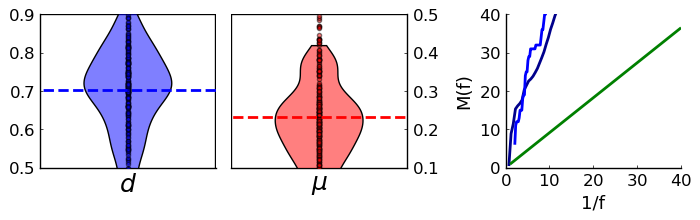

In [111]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

0.7063067923233356
0.3010233654610043


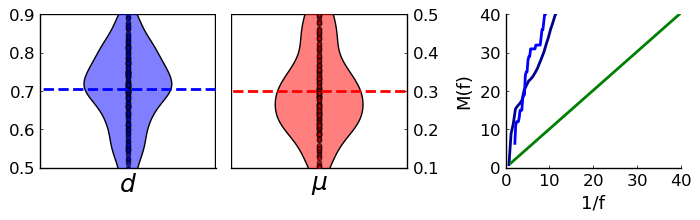

In [226]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 0.9)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.1, 0.5)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

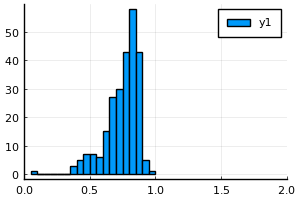

In [112]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )

> sub 35

0.8479352003063672
0.10153956633088367


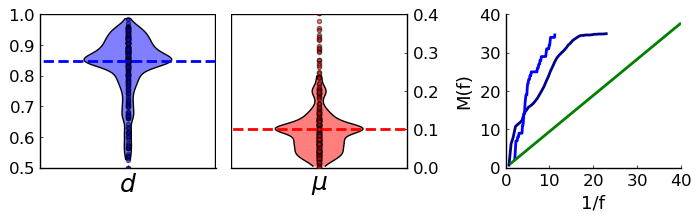

In [240]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

ylim = (0.5, 1.)
xlim = (0.2, 1.8)
plot!(p[1], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, xticks=([1],[L"d"]))
hline!(p[1], [ylim[2]], c=:black, lw=1.7)
vline!(p[1], [xlim[2]], c=:black, lw=1.7)
violin!(p[1], [1], ds[ ds .> quantile(ds, 0.05)], c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5, ms = 3)
hline!(p[1], [median(ds)], c=:blue, lw=2., style=:dash)
println(median(ds))

xlim = (0.2, 1.8)
ylim = (0.0, 0.4)
yticks = range(ylim..., step=0.1)
plot!(p[2], legend=:none, xlim=xlim, xtickfontsize=18, ylim=ylim, yticks=yticks, xticks=([1],[L"\mu"]), ymirror=true)
hline!(p[2], [ylim[2]], c=:black, lw=1.7)
vline!(p[2], [xlim[1]], c=:black, lw=1.7)
violin!(p[2], [1], filter( mu -> mu < quantile(mus, 0.9), mus), c=:red, fillalpha=0.5)
scatter!(p[2], [1], mus, c=:red, alpha=0.5, ms = 3)
hline!(p[2], [median(mus)], c=:red, lw=2., style=:dash)
println(median(mus))

res = 1/40
plot!(p[end], tickfontsize=12, labelfontsize=13)
mutations = union(sanger_coinc.mutations...)
M!(p[end], collect(values(freqs)), nbins=50, lab="wes scaled", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40), c=:darkblue, scale=length(mutations)/length(freqs))
M!(p[end], [freqs[m] for m in mutations], lw=2., lab="wes filtered", c=:blue)
plot!(p[end], 1:40, x-> x*median(ds)/(1-median(mus)), lw=2., lab="", c=:green)

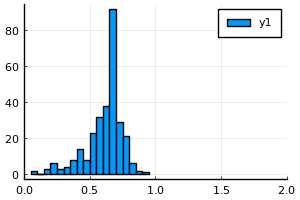

In [241]:
histogram( mus ./ (1 .- ds), size=(300,200), xlim=(0,2) )